<a href="https://colab.research.google.com/github/Tyrostir/collab/blob/main/AlgoTrading/AlgoTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
try:
  os.chdir('drive/My Drive/Colab Notebooks/')
except FileNotFoundError as e:
  pass
os.getcwd()

'/content/drive/My Drive/Colab Notebooks'

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Softmax
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from collections import deque
import time
import matplotlib.pyplot as plt
from datetime import datetime

In [5]:
LOOKUP_STEPS = 15

In [6]:
instruments = [
    {'exchange': 'INDICES', 'symbol': 'NIFTY BANK', 'dExchange': 'NFO', 'NFOSymbol': 'BANKNIFTY', 'mod': 100},
    {'exchange': 'INDICES', 'symbol': 'NIFTY 50', 'dExchange': 'NFO', 'NFOSymbol': 'NIFTY', 'mod': 50},

    {'exchange': 'NSE', 'symbol': 'HDFCBANK'},
    {'exchange': 'NSE', 'symbol': 'HDFCAMC'},
    {'exchange': 'NSE', 'symbol': 'HDFCLIFE'},

    {'exchange': 'NSE', 'symbol': 'ICICIBANK'},
    {'exchange': 'NSE', 'symbol': 'ICICIGI'},
    {'exchange': 'NSE', 'symbol': 'ICICIPRULI'},

    {'exchange': 'NSE', 'symbol': 'KOTAKBANK'},

    {'exchange': 'NSE', 'symbol': 'SBIN'},
    {'exchange': 'NSE', 'symbol': 'SBICARD'},
    {'exchange': 'NSE', 'symbol': 'SBILIFE'},

    {'exchange': 'NSE', 'symbol': 'AXISBANK'},

    {'exchange': 'NSE', 'symbol': 'INDUSINDBK'},
    {'exchange': 'NSE', 'symbol': 'INDUSTOWER'},

    {'exchange': 'NSE', 'symbol': 'AUBANK'},

    {'exchange': 'NSE', 'symbol': 'BANDHANBNK'},

    {'exchange': 'NSE', 'symbol': 'BANKBARODA'},

    {'exchange': 'NSE', 'symbol': 'RBLBANK'},

    {'exchange': 'NSE', 'symbol': 'PNB'},

    {'exchange': 'NSE', 'symbol': 'RELIANCE'},

    {'exchange': 'NSE', 'symbol': 'INFY'},

    {'exchange': 'NSE', 'symbol': 'TCS'},

    {'exchange': 'NSE', 'symbol': 'WIPRO'},

    {'exchange': 'NSE', 'symbol': 'HCLTECH'},

    {'exchange': 'NSE', 'symbol': 'TATACHEM'},
    {'exchange': 'NSE', 'symbol': 'TATACOMM'},
    {'exchange': 'NSE', 'symbol': 'TATACONSUM'},
    {'exchange': 'NSE', 'symbol': 'TATAMOTORS'},
    {'exchange': 'NSE', 'symbol': 'TATAPOWER'},
    {'exchange': 'NSE', 'symbol': 'TATASTEEL'},
]

In [7]:
dfs = {}

for instrument in instruments:
    symbol = instrument['symbol'].upper()
    exchange = instrument['exchange'].upper()
    index = exchange=='INDICES'
    if os.path.exists(f'inputData/{symbol}.csv'):
        df = pd.read_csv(f'inputData/{symbol}.csv')
        df.set_index('datetime', inplace=True)
        print(f'Fetched df for {symbol}')
    else:
        try:
            i = ab.get_instrument_by_symbol(exchange, symbol)
            print(f'Fetching df for {symbol}')
            df = ab.get_historical(i, fromdate, todate, '1', index)
            if index:
                df.drop(columns=['volume'], inplace=True)
            df = df[(df['datetime'] >= fromdate.strftime('%Y-%m-%d')) & (df['datetime'] <= todate.strftime('%Y-%m-%d'))]
            df.set_index('datetime', inplace=True)
            print(f'{symbol} Success')
        except Exception as e:
            print(instrument, e)
            break
    columns = df.columns
    for col in columns:
        if symbol not in col:
            df.rename(columns={col: f'{symbol}_{col}'}, inplace=True)
    dfs[symbol] = df

Fetched df for NIFTY BANK
Fetched df for NIFTY 50
Fetched df for HDFCBANK
Fetched df for HDFCAMC
Fetched df for HDFCLIFE
Fetched df for ICICIBANK
Fetched df for ICICIGI
Fetched df for ICICIPRULI
Fetched df for KOTAKBANK
Fetched df for SBIN
Fetched df for SBICARD
Fetched df for SBILIFE
Fetched df for AXISBANK
Fetched df for INDUSINDBK
Fetched df for INDUSTOWER
Fetched df for AUBANK
Fetched df for BANDHANBNK
Fetched df for BANKBARODA
Fetched df for RBLBANK
Fetched df for PNB
Fetched df for RELIANCE
Fetched df for INFY
Fetched df for TCS
Fetched df for WIPRO
Fetched df for HCLTECH
Fetched df for TATACHEM
Fetched df for TATACOMM
Fetched df for TATACONSUM
Fetched df for TATAMOTORS
Fetched df for TATAPOWER
Fetched df for TATASTEEL


In [8]:
try:
  os.mkdir('results')
except FileExistsError as e:
  pass

In [9]:
dfs['NIFTY BANK']

,NIFTY BANK_open,NIFTY BANK_high,NIFTY BANK_low,NIFTY BANK_close
datetime,,,,
2023-01-02 09:15:59,43038.25,43134.00,43036.00,43134.00
2023-01-02 09:16:59,43135.40,43151.25,43097.20,43118.30
2023-01-02 09:17:59,43116.50,43121.55,43071.55,43105.70
2023-01-02 09:18:59,43108.20,43108.60,43061.40,43077.45
2023-01-02 09:19:59,43076.55,43091.65,43025.25,43025.25
...,...,...,...,...
2023-08-25 15:26:59,44201.70,44203.65,44197.50,44200.15
2023-08-25 15:27:59,44197.25,44202.15,44172.90,44177.20
2023-08-25 15:28:59,44171.20,44177.10,44134.55,44160.75


In [10]:
dfsl = []
for key, df in dfs.items():
    dfsl.append(df)

In [11]:
df = pd.concat(dfsl, axis=1)
# add date as a column
if 'datestr' not in df.columns:
    df['datestr'] = df.index
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df.index)
df['weekday'] = df['date'].apply(lambda x: x.weekday())
df['day'] = df['date'].apply(lambda x: x.day)
df['month'] = df['date'].apply(lambda x: x.month)
df.drop(columns=['date', 'datestr'], inplace=True)
df['date'] = df.index # pd.to_datetime(df.index)
df.dropna(axis=0, inplace=True)

In [12]:
df

,NIFTY BANK_open,NIFTY BANK_high,NIFTY BANK_low,NIFTY BANK_close,NIFTY 50_open,NIFTY 50_high,NIFTY 50_low,NIFTY 50_close,HDFCBANK_open,HDFCBANK_high,...,TATAPOWER_volume,TATASTEEL_open,TATASTEEL_high,TATASTEEL_low,TATASTEEL_close,TATASTEEL_volume,weekday,day,month,date
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-02 09:15:59,43038.25,43134.00,43036.00,43134.00,18131.70,18153.20,18117.05,18141.35,1627.00,1628.15,...,154537.0,114.40,114.40,113.75,114.10,1311968.0,0,2,1,2023-01-02 09:15:59
2023-01-02 09:16:59,43135.40,43151.25,43097.20,43118.30,18142.20,18145.70,18131.40,18135.65,1626.85,1626.85,...,73872.0,114.10,114.75,114.10,114.60,963420.0,0,2,1,2023-01-02 09:16:59
2023-01-02 09:17:59,43116.50,43121.55,43071.55,43105.70,18133.25,18140.55,18120.65,18140.55,1625.80,1627.90,...,106805.0,114.60,115.20,114.50,115.05,1922254.0,0,2,1,2023-01-02 09:17:59
2023-01-02 09:18:59,43108.20,43108.60,43061.40,43077.45,18139.40,18139.40,18120.15,18130.75,1627.00,1627.50,...,59720.0,115.05,115.30,115.00,115.25,989051.0,0,2,1,2023-01-02 09:18:59
2023-01-02 09:19:59,43076.55,43091.65,43025.25,43025.25,18130.30,18133.55,18112.15,18112.15,1625.70,1626.15,...,43769.0,115.20,115.60,115.15,115.45,1884521.0,0,2,1,2023-01-02 09:19:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-25 15:25:59,44212.50,44218.10,44200.55,44202.35,19247.35,19248.95,19244.55,19246.05,1561.00,1561.00,...,97812.0,117.00,117.10,116.95,117.00,268577.0,4,25,8,2023-08-25 15:25:59
2023-08-25 15:26:59,44201.70,44203.65,44197.50,44200.15,19245.60,19248.30,19243.30,19247.20,1560.30,1560.30,...,102959.0,117.05,117.10,117.00,117.05,272864.0,4,25,8,2023-08-25 15:26:59
2023-08-25 15:27:59,44197.25,44202.15,44172.90,44177.20,19246.85,19246.85,19241.55,19245.10,1560.00,1560.15,...,95296.0,117.00,117.10,116.90,117.00,229536.0,4,25,8,2023-08-25 15:27:59


In [13]:
FEATURES = list(df.columns[:-2])
TARGET = 'NIFTY BANK_close'
FEATURES

['NIFTY BANK_open',
 'NIFTY BANK_high',
 'NIFTY BANK_low',
 'NIFTY BANK_close',
 'NIFTY 50_open',
 'NIFTY 50_high',
 'NIFTY 50_low',
 'NIFTY 50_close',
 'HDFCBANK_open',
 'HDFCBANK_high',
 'HDFCBANK_low',
 'HDFCBANK_close',
 'HDFCBANK_volume',
 'HDFCAMC_open',
 'HDFCAMC_high',
 'HDFCAMC_low',
 'HDFCAMC_close',
 'HDFCAMC_volume',
 'HDFCLIFE_open',
 'HDFCLIFE_high',
 'HDFCLIFE_low',
 'HDFCLIFE_close',
 'HDFCLIFE_volume',
 'ICICIBANK_open',
 'ICICIBANK_high',
 'ICICIBANK_low',
 'ICICIBANK_close',
 'ICICIBANK_volume',
 'ICICIGI_open',
 'ICICIGI_high',
 'ICICIGI_low',
 'ICICIGI_close',
 'ICICIGI_volume',
 'ICICIPRULI_open',
 'ICICIPRULI_high',
 'ICICIPRULI_low',
 'ICICIPRULI_close',
 'ICICIPRULI_volume',
 'KOTAKBANK_open',
 'KOTAKBANK_high',
 'KOTAKBANK_low',
 'KOTAKBANK_close',
 'KOTAKBANK_volume',
 'SBIN_open',
 'SBIN_high',
 'SBIN_low',
 'SBIN_close',
 'SBIN_volume',
 'SBICARD_open',
 'SBICARD_high',
 'SBICARD_low',
 'SBICARD_close',
 'SBICARD_volume',
 'SBILIFE_open',
 'SBILIFE_high',
 

In [14]:
result = {}
result['backup_df'] = df.copy()
result['df'] = df
for col in FEATURES:
    assert col in df.columns, f'{col} doesnot exist in the dataframe.'

In [15]:
column_scaler = {}
for col in FEATURES:
    scaler = preprocessing.MinMaxScaler()
    df[col] = scaler.fit_transform(np.expand_dims(df[col].values, axis=1))
    column_scaler[col] = scaler
result['column_scaler'] = column_scaler

In [16]:
df['future'] = df[TARGET].shift(-LOOKUP_STEPS)

<ipython-input-16-935e58db7bce>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['future'] = df[TARGET].shift(-LOOKUP_STEPS)


In [17]:
last_sequence = np.array(df[FEATURES].tail(LOOKUP_STEPS))

In [18]:
df.dropna(inplace=True)
df

,NIFTY BANK_open,NIFTY BANK_high,NIFTY BANK_low,NIFTY BANK_close,NIFTY 50_open,NIFTY 50_high,NIFTY 50_low,NIFTY 50_close,HDFCBANK_open,HDFCBANK_high,...,TATASTEEL_open,TATASTEEL_high,TATASTEEL_low,TATASTEEL_close,TATASTEEL_volume,weekday,day,month,date,future
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-02 09:15:59,0.571368,0.581097,0.572074,0.584087,0.411662,0.417005,0.408210,0.414677,0.415073,0.418652,...,0.563193,0.560976,0.539823,0.550885,0.077545,0.0,0.033333,1,2023-01-02 09:15:59,0.565245
2023-01-02 09:16:59,0.583935,0.583331,0.579990,0.582056,0.414991,0.414627,0.412756,0.412869,0.414398,0.412809,...,0.549889,0.576497,0.555310,0.573009,0.056901,0.0,0.033333,1,2023-01-02 09:16:59,0.567399
2023-01-02 09:17:59,0.581490,0.579485,0.576673,0.580426,0.412154,0.412994,0.409351,0.414423,0.409674,0.417528,...,0.572062,0.596452,0.573009,0.592920,0.113692,0.0,0.033333,1,2023-01-02 09:17:59,0.568350
2023-01-02 09:18:59,0.580417,0.577809,0.575360,0.576771,0.414104,0.412629,0.409192,0.411315,0.415073,0.415730,...,0.592018,0.600887,0.595133,0.601770,0.058420,0.0,0.033333,1,2023-01-02 09:18:59,0.581118
2023-01-02 09:19:59,0.576322,0.575614,0.570684,0.570018,0.411218,0.410774,0.406658,0.405417,0.409224,0.409663,...,0.598670,0.614191,0.601770,0.610619,0.111457,0.0,0.033333,1,2023-01-02 09:19:59,0.586415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-25 15:10:59,0.731916,0.730241,0.732359,0.732216,0.777269,0.776000,0.776699,0.775886,0.128684,0.127640,...,0.676275,0.674058,0.679204,0.674779,0.002493,1.0,0.800000,8,2023-08-25 15:10:59,0.722293
2023-08-25 15:11:59,0.731599,0.729400,0.729597,0.729046,0.775969,0.774494,0.773230,0.772445,0.126434,0.125169,...,0.676275,0.674058,0.679204,0.674779,0.006408,1.0,0.800000,8,2023-08-25 15:11:59,0.722009
2023-08-25 15:12:59,0.728883,0.728183,0.726034,0.725676,0.772845,0.772100,0.769714,0.768893,0.123285,0.125169,...,0.674058,0.671840,0.674779,0.672566,0.005537,1.0,0.800000,8,2023-08-25 15:12:59,0.719040


In [19]:
seq_data = []
seq = deque(maxlen=60)

In [20]:
for entry, target in zip(df[FEATURES + ['date']].values, df['future'].values):
    seq.append(entry)
    if len(seq) == 60:
        seq_data.append([np.array(seq), target])

In [21]:
len(seq_data)

59250

In [22]:
# get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
# for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
# this last_sequence will be used to predict future stock prices that are not available in the dataset
last_sequence = list([s[:len(FEATURES)] for s in seq]) + list(last_sequence)
last_sequence = np.array(last_sequence).astype(np.float32)
# add to result
result['last_sequence'] = last_sequence

In [23]:
# construct the X's and y's
X_list, y_list = [], []
for i, dat in enumerate(seq_data):
    # if i == 50000:
        # break
    seq, target = dat
    X_list.append(seq)
    y_list.append(target)

In [24]:
len(X_list)

59250

In [25]:
MAX_INPUT=10000
processed = 0
total = len(X_list)

In [26]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error", "accuracy"], optimizer=optimizer)
    return model

In [27]:
sequence_length = 60
n_features = len(FEATURES)
units=128
cell = LSTM
n_layers = 2
dropout = 0.4
loss = 'huber_loss'
optimizer = "adam"
bidirectional = True
BATCH_SIZE = 64
EPOCHS = 50
SHUFFLE = False
SHUFFLE_STR = f"sh-{int(SHUFFLE)}"
SCALE = True
SCALE_STR = f"sc-{int(SCALE)}"
SPLIT_BY_DATE = True
SPLIT_BY_DATE_STR = f"sbd-{int(SPLIT_BY_DATE)}"
sequence_number = 60
lookup_step = LOOKUP_STEPS
model_name = f"{datetime.now().strftime('%Y-%m-%d')}_NIFTY-{SHUFFLE_STR}-{SCALE_STR}-{SPLIT_BY_DATE_STR}-{loss}-{optimizer}-{cell.__name__}-seq-{sequence_number}-step-{lookup_step}-layers-{n_layers}-units-{units}"
TEST_SIZE = 0.2
multiplier = 1
low = 0
high = 0
model = create_model(sequence_length, n_features, units=units, cell=cell, n_layers=n_layers, dropout=dropout, loss=loss, optimizer=optimizer, bidirectional=bidirectional)
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
if os.path.isfile(model_path):
    model.load_weights(model_path)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
earlystop = EarlyStopping(monitor='loss', patience=3)
while processed < (total-1):
  low = processed
  high = multiplier * MAX_INPUT
  multiplier += 1
  X = np.array(X_list[low:high])
  y = np.array(y_list[low:high])
  processed = high
  # split the dataset into training & testing sets by date (not randomly splitting)
  train_samples = int((1 - TEST_SIZE) * len(X))
  result["X_train"] = X[:train_samples]
  result["y_train"] = y[:train_samples]
  result["X_test"]  = X[train_samples:]
  result["y_test"]  = y[train_samples:]
  # get the list of test set dates
  dates = result['X_test'][:, -1, -1]
  # retrieve test features from the original dataframe
  result["test_df"] = result["df"].loc[dates]
  # remove duplicated dates in the testing dataframe
  result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
  # remove dates from the training/testing sets & convert to float32
  result["X_train"] = result["X_train"][:, :, :len(FEATURES)].astype(np.float32)
  result["X_test"] = result["X_test"][:, :, :len(FEATURES)].astype(np.float32)
  # result['df'].to_csv('inputData_scaled.csv')
  # train the model and save the weights whenever we see
  # a new optimal model using ModelCheckpoint
  history = model.fit(result["X_train"], result["y_train"],
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(result["X_test"], result["y_test"]),
                      callbacks=[checkpointer, tensorboard, earlystop],
                      verbose=1)


Epoch 1/50
124/125 [============================>.] - ETA: 0s - loss: 0.0243 - mean_absolute_error: 0.1170 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.00101, saving model to results/2023-09-06_NIFTY-sh-0-sc-1-sbd-1-huber_loss-adam-LSTM-seq-60-step-15-layers-2-units-128.h5
125/125 [==============================] - 16s 34ms/step - loss: 0.0242 - mean_absolute_error: 0.1165 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_mean_absolute_error: 0.0392 - val_accuracy: 0.0000e+00
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0408 - accuracy: 0.0000e+00
Epoch 2: val_loss did not improve from 0.00101
125/125 [==============================] - 2s 18ms/step - loss: 0.0013 - mean_absolute_error: 0.0408 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_mean_absolute_error: 0.0476 - val_accuracy: 0.0000e+00
Epoch 3/50
124/125 [============================>.] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.0355 - accuracy: 0.

In [28]:
loss, mae, accuracy = model.evaluate(result['X_test'], result['y_test'], verbose=0)
loss, mae, accuracy

(0.0005195378907956183, 0.028103457763791084, 0.0)

In [29]:
result['column_scaler'][TARGET].inverse_transform([[mae]])[0][0]

38836.192538859876

In [30]:
TARGET_COLUMN = TARGET
LOOKUP_STEP = LOOKUP_STEPS

def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to
    construct a final dataframe that includes the features along
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current,
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"][TARGET_COLUMN].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"][TARGET_COLUMN].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"{TARGET_COLUMN}_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_{TARGET_COLUMN}_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit,
                                    final_df[TARGET_COLUMN],
                                    final_df[f"{TARGET_COLUMN}_{LOOKUP_STEP}"],
                                    final_df[f"true_{TARGET_COLUMN}_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit,
                                    final_df[TARGET_COLUMN],
                                    final_df[f"{TARGET_COLUMN}_{LOOKUP_STEP}"],
                                    final_df[f"true_{TARGET_COLUMN}_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [31]:
# get the final dataframe for the testing set
final_df = get_final_df(model, result)

58/58 [==============================] - 2s 8ms/step


In [32]:
N_STEPS = 60
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"][TARGET_COLUMN].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [33]:
# predict the future price
future_price = predict(model, result)
future_price

1/1 [==============================] - 0s 25ms/step


43881.41

In [34]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{loss} loss:", loss)
print("Mean Absolute Error:", mae)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 15 days is 43881.41$
0.0005195378907956183 loss: 0.0005195378907956183
Mean Absolute Error: 0.028103457763791084
Accuracy score: 1.0
Total buy profit: 81856058.46602178
Total sell profit: 0
Total profit: 81856058.46602178
Profit per trade: 44246.5180897415


In [35]:
# plot true/pred prices graph
test_df = final_df.copy()
# test_df.index = pd.to_datetime(test_df.index)

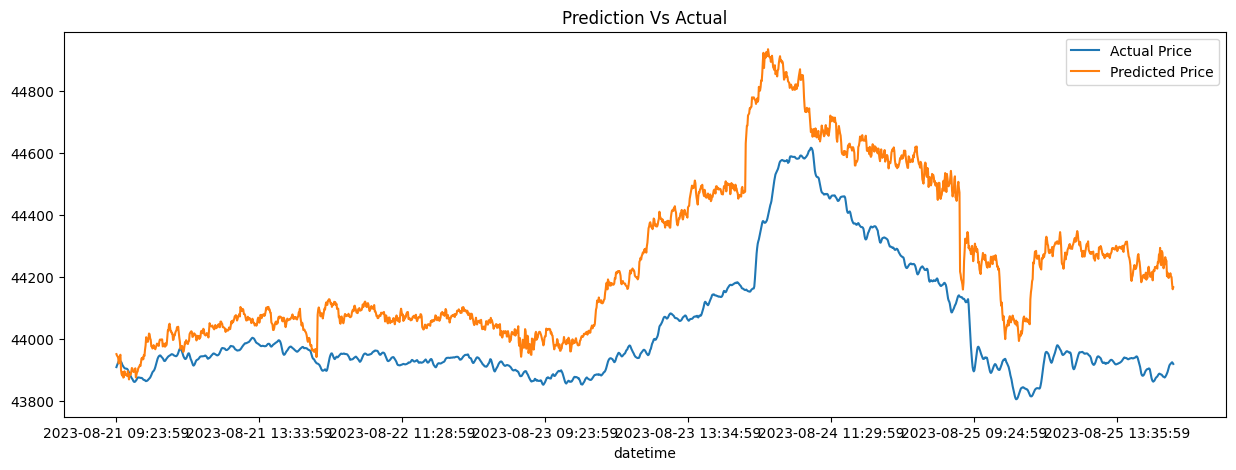

In [36]:
# plt.plot(test_df[f'true_{TARGET_COLUMN}_{LOOKUP_STEP}'], c='b')
fig, ax = plt.subplots(figsize=(15,5))
test_df[f'{TARGET_COLUMN}_{LOOKUP_STEP}'].plot(ax=ax, label='PREDICTION', title='Prediction Vs Actual')
test_df[f'true_{TARGET_COLUMN}_{LOOKUP_STEP}'].plot(ax=ax, label='ACTUAL')
ax.legend(["Actual Price", "Predicted Price"])
plt.show()

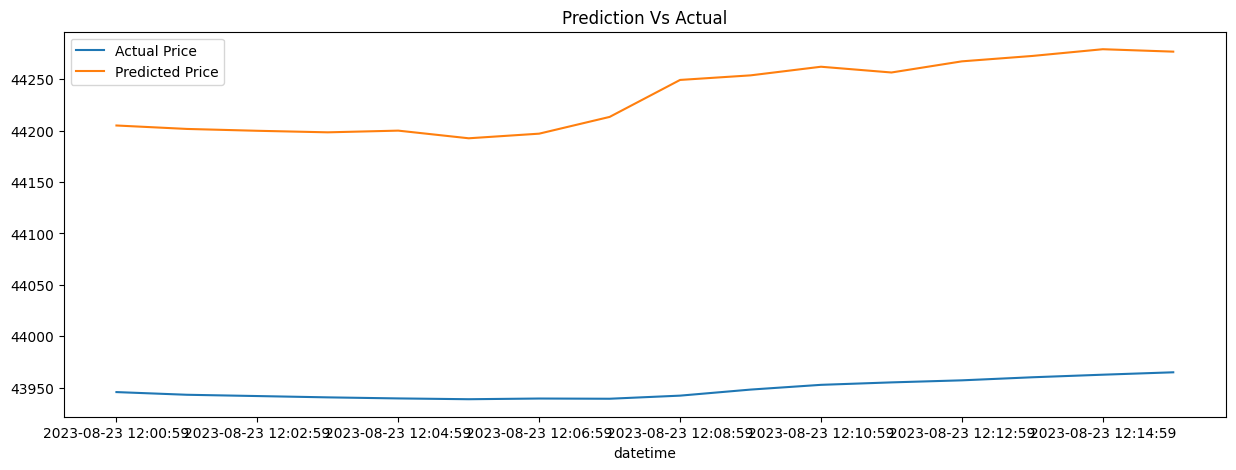

In [37]:
# plt.plot(test_df[f'true_{TARGET_COLUMN}_{LOOKUP_STEP}'], c='b')

minDate = '2023-08-23 12:00'
maxDate = '2023-08-23 12:16'
pred = test_df[(test_df['date'] > minDate) & (test_df['date'] < maxDate)][f'{TARGET_COLUMN}_{LOOKUP_STEP}']
act = test_df[(test_df['date'] > minDate) & (test_df['date'] < maxDate)][f'true_{TARGET_COLUMN}_{LOOKUP_STEP}']
fig, ax = plt.subplots(figsize=(15,5))
pred.plot(ax=ax, label='PREDICTION', title='Prediction Vs Actual')
act.plot(ax=ax, label='ACTUAL')
ax.legend(["Actual Price", "Predicted Price"])
plt.show()